In [30]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
#from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import re

In [13]:
#NETTOYAGE DU JEU DE DONNEES

def average_mean(df,journée_depart, num_journée=4):
    '''
    Arguments : df, dataframe pandas, jeu de données contenant les notes des dernières journées dans les colonnes j0,j-1,j-2 etc
    depart : int, journée de départ : 19 pour la 19 ème journée
    num_jurnée : int entre 0 et 38 , nombre de journées prises en compte pour calculer la moyenne mobile
    Sortie :
    une series pandas avec la moyenne mobile des notes de chaque ligne (joueur)du jeu de donnée initial 
    ''' 
    ##On pourrait prendre simplement la moyenne (.mean(axis=1) pour chaque joueur mais ici on divise par le nombre de journées effectivement jouées:
      # si on a par exemple 6,7,8, 0 , on divise seulement par 3 et la moyenne sera de 7 ) ,pour cela on utilise la fonction de numpy
        # np.count_nonzero
    return df[[f'j{journée_depart-day}' for day in range(num_journée)]].sum(axis=1)/np.count_nonzero(df[[f'j{journée_depart-day}' for day in range(num_journée)]], axis=1)

In [33]:
def concat_journées(list_days,intervalle=4):
    """
    Arguments :
    list_days, list, nom des fichiers excels que l'on doit ouvrir
    intervalle : int, Argument de la fonction average_mean
    Output : pandas dataframe, Jeu de donnée concaténé avec une colonne en plus crée avec la fonction average_mean (moyenne mobile des notes)
    """
    list_dfs = []
    #on parcourt toutes les saisons
    for journee in list_days:
        #numéro de la saison : par exemple pour PL J19.xlsx ce sera 19
        #on utilise un regex pour extraire le chiffre ; [0-9] = tout chiffre entre 0 et 9 , {1,2} = présents une ou deux fois (on pourrait mettre 4 si les noms de fichiers étaient du style 2018 , 2019 etc)
        num_journée = int(re.search(r'[0-9]{1,2}',journee).group(0)) 
        #on ouvre le fichier avec header = 2
        df = pd.read_excel(journee,header=2)
        
        df["moy_j"]= average_mean(df,num_journée,intervalle)
        df["moy_j_10"]= average_mean(df,num_journée,10)
        #on remplit valeur manquantes par '0'
        df = df.fillna('0')
        #renommage des colonnes
        df.rename(columns={'%Titu': 'Titu',
                   '%Titu série': 'Titu série',
                   '%Titu 1 an': 'Titu 1 an',
                   '%Passes': 'Passes',
                   '%Duel': 'Duel',
                   '%Win+12J': 'Win12J',
                   '%Win+16J': 'Win16J',
                   '%Win+20J': 'Win20J'}, inplace=True)
         # On remplace j29 j28 j27 ... j1 j38 j37 etc par j-1 j-2 j-3 afin d'uniformiser colonnes selon les journées de reference
        df[[f'j-{i+1}' for i in range(38)] ]= df.iloc[:,[29+i for i in range(38)]].copy()
        #par exemple df[j29] devient df[j-1] etc
        
        #transforme les données non numériques en float 
        df['Cote'] = df['Cote'].astype('float64')
        df['Enchère moy'] = df['Enchère moy'].astype('float64')
        df['Cleansheet'] = df['Cleansheet'].astype('float64')
        df['But/Peno'] = df['But/Peno'].astype('float64')
        df['But/Coup-franc'] = df['But/Coup-franc'].astype('float64')
        df['But/surface'] = df['But/surface'].astype('float64')
        df['Pass decis.'] = df['Pass decis.'].astype('float64')
        df['Passes'] = df['Passes'].astype('float64')
        df['Ballons'] = df['Ballons'].astype('float64')
        df['Interceptions'] = df['Interceptions'].astype('float64')
        df['Tacles'] = df['Tacles'].astype('float64')
        df['Duel'] = df['Duel'].astype('float64')
        df['Fautes'] = df['Fautes'].astype('float64')
        df['But évité'] = df['But évité'].astype('float64')
        df['Min/But'] = df['Min/But'].astype('float64')
        df['Min/But 1 an'] = df['Min/But 1 an'].astype('float64')
        df['Min note/but'] = df['Min note/but'].astype('float64')
        df['Action stoppée'] = df['Action stoppée'].astype('float64')
        df['Occas° créée'] = df['Occas° créée'].astype('float64')
        df['Corner gagné'] = df['Corner gagné'].astype('float64')
        df['moy_j'] = df['moy_j'].astype('float64')
        
        #supprime les colonnes non utiles 
        df = df.drop(['Club', 'Prochain opposant', 'Date', 'Victoire probable', 'Win12J', 'Win16J', 'Win20J'], axis = 1) 
        # on supprime les anciennes colonnesde notes par journées
        df = df.drop(columns=list(df.columns[29:(29+38)]))   
        list_dfs.append(df)
    #on concatene toutes les saisons :
    df_final = pd.concat(list_dfs).reset_index(drop=True)
    return df_final.drop(columns=["Dispo@MPGLaurent?"])

In [34]:
#concat les données comportant des cotes actualisées sur les quatres principaux championnats 
df = concat_journées(["PL J29.xlsx","FR J29.xlsx","ES J27.xlsx","IT J27.xlsx", "IT J15.xlsx", "LF J17.xlsx", "PL J23.xlsx"])

In [36]:
df.head()

,Joueur,Poste,Cote,Enchère moy,Note,Note série,Note 1 an,Nb match,Nb match série,Nb match 1 an,...,j-29,j-30,j-31,j-32,j-33,j-34,j-35,j-36,j-37,j-38
0,Haaland Erling,A,48.0,125.0,6.15,0.00,6.15,26,0,26,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Kane Harry,A,52.0,93.0,6.16,6.16,6.24,29,29,42,...,5.5,8.0,5.0,5.0,6.5,5.0,4.0,8.0,6.5,7.0
2,Toney Ivan,A,36.0,61.0,5.69,5.44,5.67,26,9,36,...,6.0,4.5,4.0,7.0,4.0,5.0,4.5,7.5,7.0,4.5
3,Rashford Marcus,A,29.0,95.0,5.67,5.67,5.31,27,27,35,...,3.5,0.0,4.5,0.0,0.0,4.5,4.0,4.0,4.0,2.5
4,Gabriel Martinelli,MO,25.0,40.0,5.93,5.93,5.76,29,29,42,...,7.0,8.0,4.5,6.0,6.5,4.0,4.5,4.0,4.5,0.0


In [38]:
df.columns

Index(['Joueur', 'Poste', 'Cote', 'Enchère moy', 'Note', 'Note série',
       'Note 1 an', 'Nb match', 'Nb match série', 'Nb match 1 an', 'Variation',
       'Var série', 'Var 1 an', 'But', 'Buts série', 'Buts 1 an', 'Titu',
       'Titu série', 'Titu 1 an', 'Temps', 'Tps série', 'Tps 1 an', 'Tps moy',
       'Tps moy série', 'Tps moy 1 an', 'Min/But', 'Min/But 1 an',
       'Min note/but', 'Prix/but', 'Cleansheet', 'But/Peno', 'But/Coup-franc',
       'But/surface', 'Pass decis.', 'Occas° créée', 'Corner gagné', 'Passes',
       'Ballons', 'Interceptions', 'Tacles', 'Duel', 'Fautes', 'But évité',
       'Action stoppée', 'DMI', 'moy_j', 'moy_j_10', 'j-1', 'j-2', 'j-3',
       'j-4', 'j-5', 'j-6', 'j-7', 'j-8', 'j-9', 'j-10', 'j-11', 'j-12',
       'j-13', 'j-14', 'j-15', 'j-16', 'j-17', 'j-18', 'j-19', 'j-20', 'j-21',
       'j-22', 'j-23', 'j-24', 'j-25', 'j-26', 'j-27', 'j-28', 'j-29', 'j-30',
       'j-31', 'j-32', 'j-33', 'j-34', 'j-35', 'j-36', 'j-37', 'j-38'],
      dtype='objec

In [39]:
def count_titularisations(liste_journées):
    """
    liste_journées = liste des notes des 38 dernières journées 
    renvoie le nombre de notes non nulles avec la fonctionnp.count_nonzero
    
    """
    return np.count_nonzero (liste_journées)
# ici on compte titularisations sur 38 journées 
print([ f'j-{i+1}' for i in range(38)])
df.apply(lambda x : count_titularisations([ x[f'j-{i+1}'] for i in range(38)]),axis=1)

['j-1', 'j-2', 'j-3', 'j-4', 'j-5', 'j-6', 'j-7', 'j-8', 'j-9', 'j-10', 'j-11', 'j-12', 'j-13', 'j-14', 'j-15', 'j-16', 'j-17', 'j-18', 'j-19', 'j-20', 'j-21', 'j-22', 'j-23', 'j-24', 'j-25', 'j-26', 'j-27', 'j-28', 'j-29', 'j-30', 'j-31', 'j-32', 'j-33', 'j-34', 'j-35', 'j-36', 'j-37', 'j-38']


0       26
1       38
2       35
3       33
4       37
        ..
3920     0
3921     0
3922     0
3923     0
3924     0
Length: 3925, dtype: int64

In [40]:
#nombre de titularisation sur 4 matchs
print([ f'j-{i+1}' for i in range(4)])
df['Titu_4'] = df.apply(lambda x : count_titularisations([ x[f'j-{i+1}'] for i in range(4)]),axis=1)

['j-1', 'j-2', 'j-3', 'j-4']


In [41]:
df.head()

,Joueur,Poste,Cote,Enchère moy,Note,Note série,Note 1 an,Nb match,Nb match série,Nb match 1 an,...,j-30,j-31,j-32,j-33,j-34,j-35,j-36,j-37,j-38,Titu_4
0,Haaland Erling,A,48.0,125.0,6.15,0.00,6.15,26,0,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,Kane Harry,A,52.0,93.0,6.16,6.16,6.24,29,29,42,...,8.0,5.0,5.0,6.5,5.0,4.0,8.0,6.5,7.0,4
2,Toney Ivan,A,36.0,61.0,5.69,5.44,5.67,26,9,36,...,4.5,4.0,7.0,4.0,5.0,4.5,7.5,7.0,4.5,4
3,Rashford Marcus,A,29.0,95.0,5.67,5.67,5.31,27,27,35,...,0.0,4.5,0.0,0.0,4.5,4.0,4.0,4.0,2.5,3
4,Gabriel Martinelli,MO,25.0,40.0,5.93,5.93,5.76,29,29,42,...,8.0,4.5,6.0,6.5,4.0,4.5,4.0,4.5,0.0,4


In [42]:
#nombre de titularisation sur 10 matchs
print([ f'j-{i+1}' for i in range(10)])
df['Titu_10'] = df.apply(lambda x : count_titularisations([ x[f'j-{i+1}'] for i in range(10)]),axis=1)

['j-1', 'j-2', 'j-3', 'j-4', 'j-5', 'j-6', 'j-7', 'j-8', 'j-9', 'j-10']


In [43]:
# export le dataframe au format csv
df.to_csv('dataset_mpg_v150423.csv')

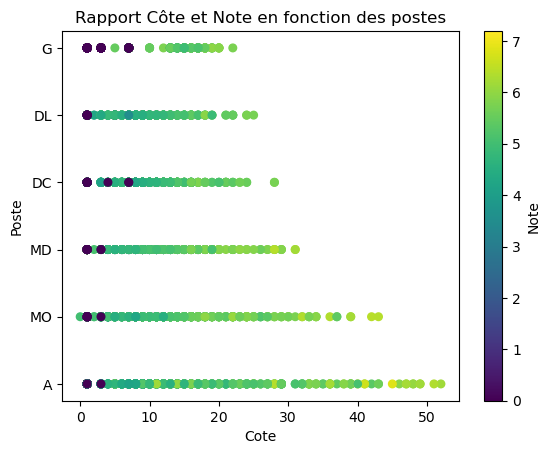

In [44]:
#DATAVISUALISATION ETUDE DES VARIABLES

df.plot.scatter(x='Cote', y='Poste', c = 'Note', s=30, cmap = 'viridis')
plt.title("Rapport Côte et Note en fonction des postes");

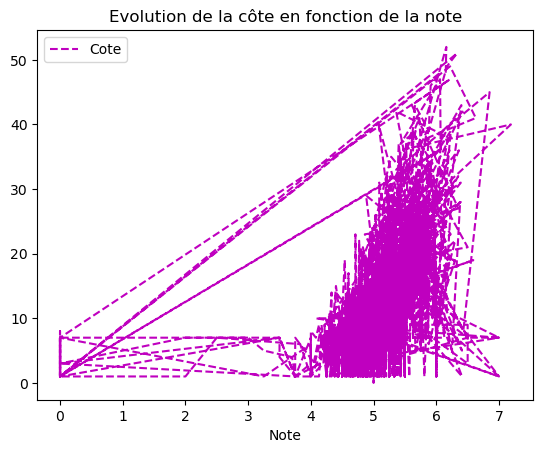

In [45]:
df.plot(x = 'Note', y = "Cote", style = ["m--", "c:."], title = "Evolution de la côte en fonction de la note");

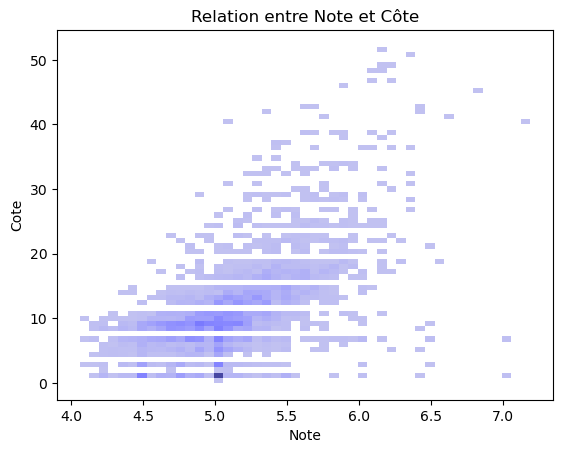

In [46]:
import seaborn as sns
sns.histplot(x='Note', y='Cote', color = 'blue',data= df[df['Note']>4]);
plt.title("Relation entre Note et Côte")
plt.show();

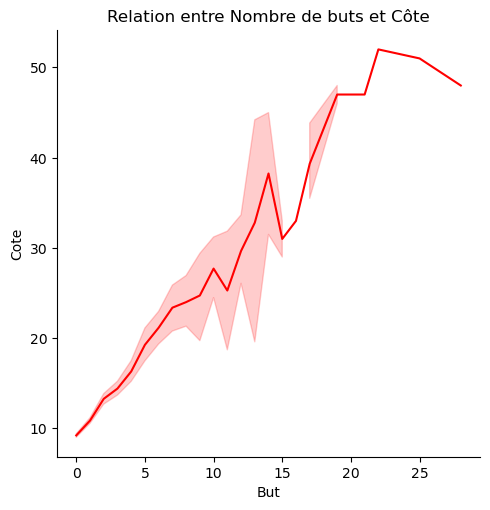

In [47]:
sns.relplot(x='But', y='Cote', color = 'red', data= df[df['Nb match']>5], kind = 'line')
plt.title("Relation entre Nombre de buts et Côte")
plt.show();

In [48]:
#SEPARATION DU JEU DE DONNEES POUR ENTRAINEMENT DES MODELES

#DF JOUEURS OFFENSIFS

df_attack = df.loc[(df['Poste'] == 'A')| (df['Poste'] == 'MO')].reset_index()

In [49]:
#DF JOUEURS DEFENSIFS

df_defense = df.loc[(df['Poste'] == 'MD')|(df['Poste'] == 'DC')|(df['Poste'] == 'DL')].reset_index()

In [50]:
#DF GARDIEN

df_goalkeeper = df.loc[(df['Poste'] == 'G')].reset_index()

In [51]:
# export df_attack au format csv
df_attack.to_csv('df_attack_mpg_v150423.csv')

In [52]:
# export df_defense au format csv
df_defense.to_csv('df_defense_mpg_v150423.csv')

In [53]:
# export df_defense au format csv
df_goalkeeper.to_csv('df_goalkeeper_mpg_v150423.csv')